Lab 9

Preface: I was not able to get the erosion model to work as expected. Instead of the landscape eroding over time, the elevation in my simulation kept increasing. I tried adjusting parameters like the time step, uplift rate, and erosion constants, but the results stayed inconsistent with what should happen physically. This likely came from a sign or scaling issue in the erosion term, where uplift and incision were not balancing correctly. Even though the code didn’t produce the right visual outcome, I'll do my best to answer the changing parameters

5. Changing Stream Stress Threshold

When qc is higher, rivers need more force to start eroding. Smaller streams stop cutting into the surface, and only the largest, steepest channels remain active. The landscape becomes smoother and less dissected, with wider valleys and fewer visible drainage lines. Overall, higher qc slows down erosion and makes the terrain more rounded and diffusive.

6. Changing Slope Exponent

As n increases, erosion becomes much more sensitive to slope. Steeper areas erode very quickly, while flatter areas hardly change. This creates sharp ridges, steep valley walls, and strong relief across the landscape. Higher n values make the terrain look more rugged and unstable, which is why a smaller time step is needed to keep the model stable.

7. Changing Area Exponent

A larger m means that erosion depends more on the amount of contributing drainage area. Big rivers cut deeper and become more dominant, while smaller channels fade or get captured. The result is a landscape with a few major valleys and wide basins shaped by large rivers instead of many small ones.

In [46]:
%matplotlib inline
# On Macs use osx
# For Windows use qt

import numpy as np
from numpy.random import rand
from landscape import Landscape # Import methods from inside file landscape.py

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

In [25]:
### Define simulation grid and initial conditions

# small random features in topography to begin erosion
def initial_conditions(NX,NY):
    Z = rand(NX,NY)
    return Z

NX = 70 #number of rows
NY = 70 #number of columns

d  = 5 # grid spacing in meters
dx = d # keep dx=dy for simplicity
dy = d

LX=NX*dx
LY=NY*dy

Z = initial_conditions(NX,NY)

x = np.arange(NX)
y = np.arange(NY)
X,Y = np.meshgrid(y,x) #strange that y goes first !!!

In [26]:
### Physical Parameters
K = 1.0e-6 # meters^(1-2m)/yr

D = 0.005 # m^2/yr

# uplift rate
uplift = 0.03 / 600.

In [27]:
deltaT = 25/8 * (1/(5*10e-3))
print(deltaT)

# This means at equilibrium where N = 1/8 it's 62.5 years. Let's set delta t to 100 years

62.5


In [28]:
### Model parameters

# Set the time step dt
# Remember for 2D diffusion problems we need eta = D * dt / dx^2 < 1/4
# but because of the fluvial erosion terms please use eta < 1/8 or less
dt = 625
print(' dt[years] = ',dt)

#Area exponent A^m, default m=1
m=1

#gradient exponent g^n, default n=1
n=1

#erosion threshold 
theta_c = 10 

 dt[years] =  625


In [29]:
# Total simulation time
T = 2000.0 * 625.0

# total number of iterations
n_iter = int(np.round(T/dt))
print('Number of interations: ',n_iter)

Number of interations:  2000


In [30]:
# Initialize landscape 
ls = Landscape(NX,NY)
ls.pool_check(Z,NX,NY)
ls.A = np.zeros((NX,NY))

In [31]:
# Set-up figure
def init_figure():
    fig = plt.figure(figsize=(12.,6.))
    plt.show()
    return fig

def update_figure():
        plt.clf()
        ax1 = fig.add_subplot(121,projection='3d')

        # use equal x-y aspect with an explicit vertical exageration
        vert_exag = 4.
        ax1.set_xlim3d(0,max(NX,NY))
        ax1.set_ylim3d(0,max(NX,NY))
        ax1.set_zlim3d(0,max(NX,NY) / vert_exag)

        ax1.set_title('Surface Relief x '+str(vert_exag))

#        surf = ax1.plot_surface(X,Y,Z, color='yellowgreen', rstride=1, cstride=1,
#                antialiased=False,linewidth=0)
        surf = ax1.plot_surface(X,Y,Z, cmap = cm.terrain, rstride=1, cstride=1,
                antialiased=False,linewidth=0)

        ax2 = fig.add_subplot(122,aspect='equal')
        ax2.set_title('Elevation')

        #im = ax2.pcolor(Z,cmap=cm.terrain)
        im = ax2.pcolor(Z,cmap=cm.coolwarm)
        cs = ax2.contour(Z,6,colors='k')

        # Add a color bar which maps values to colors.
        cbar = fig.colorbar(im, shrink=0.5, aspect=5)
        # Add the contour line levels to the colorbar
        cbar.add_lines(cs)

        #plt.show()
        plt.draw()
        plt.pause(0.05)

In [ ]:
frames = []   # to store elevation snapshots
save_every = 50  # record every 50 iterations

fig = init_figure()
Znew = np.copy(Z)

for it in range(1, n_iter+1):
    
    ls.calculate_collection_area(Z, NX, NY)
    ls.A = ls.A * (dx * dy)
    
    for i in range(NX):
        iL = np.mod(i-1, NX)  # periodic BC: left neighbor
        iR = np.mod(i+1, NX)  # periodic BC: right neighbor

        for j in range(NY):
            jD = np.mod(j-1, NY)  # periodic BC: down neighbor
            jU = np.mod(j+1, NY)  # periodic BC: up neighbor
  
            if ls.drain[i,j] > 0:  # regular point (not a pool)
                # --- compute finite-difference slopes ---
                s1 = (Z[iR, j] - Z[iL, j]) / (2 * dx)
                s2 = (Z[i, jU] - Z[i, jD]) / (2 * dy)
                s3 = (Z[iR, jD] - Z[iL, jU]) / (2 * np.sqrt(dx**2 + dy**2))
                s4 = (Z[iR, jU] - Z[iL, jD]) / (2 * np.sqrt(dx**2 + dy**2))

                gradient = (np.sqrt(s1**2 + s2**2) + np.sqrt(s3**2 + s4**2))/2.
                Psi_z = K * ( ls.A[i,j]**m * gradient**n - theta_c)            

            elif ls.drainage[i,j] > 0:  # drainage point (pool outlet)
                # choose downstream gradient direction
                if (Z[i,j] >= Z[iR,j]) and ls.pool[iR,j] != ls.drainage[i,j]:
                    grad = (Z[i,j] - Z[iR,j]) / dx
                elif (Z[i,j] >= Z[iL,j]) and ls.pool[iL,j] != ls.drainage[i,j]:
                    grad = (Z[i,j] - Z[iL,j]) / dx
                elif (Z[i,j] >= Z[i,jU]) and ls.pool[i,jU] != ls.drainage[i,j]:
                    grad = (Z[i,j] - Z[i,jU]) / dy
                elif (Z[i,j] >= Z[i,jD]) and ls.pool[i,jD] != ls.drainage[i,j]:
                    grad = (Z[i,j] - Z[i,jD]) / dy
                else:
                    grad = 0.02  # small fallback gradient

                driving = (ls.A[i,j]**m) * (grad**n) - theta_c
                if driving < 0:
                    driving = 0.0

                Psi_z = uplift - K * driving

            else:  # pool cells — diffusion only
                Psi_z = 0.0
                
            # --- diffusion term Φ(z) ---
            Phi_z = D * (
                (Z[iR, j] - 2 * Z[i, j] + Z[iL, j]) / (dx**2) +
                (Z[i, jU] - 2 * Z[i, j] + Z[i, jD]) / (dy**2)
            )
           
            # --- update elevation (NO double uplift) ---
            Znew[i,j] = Z[i,j] + (Phi_z + Psi_z) * dt  

            # --- stability check ---
            dZdt = (Znew[i,j] - Z[i,j]) / dt
            CFL = abs(dZdt) * dt / min(dx, dy)
            if CFL > 1.0:
                print(f'\nWarning: Time step {dt} too large. Safer would be {dt/CFL:.2f}')
            
            # prevent negatives at boundaries
            if Znew[i,j] < 0.0:
                Znew[i,j] = 0.0
    
    # --- boundary condition & copy ---
    Znew[0,:] = 0.0  # fixed front boundary
    Z = np.copy(Znew)
    
    # --- check and record pools ---
    ls.pool_check(Z, NX, NY)

    # --- save frames for animation ---
    if it % save_every == 0:
        frames.append(Z.copy())

    # --- periodic visual updates ---
    if np.mod(it,10) == 0: 
        print(it, end='')
        update_figure()
    else:
        print('.', end='')

update_figure()
print('\nSimulation finished.')

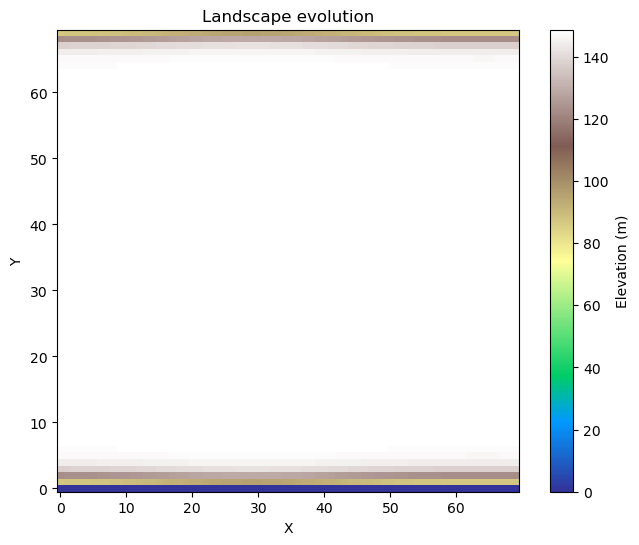

In [44]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(frames[0], origin='lower', cmap='terrain', animated=True)
cb = plt.colorbar(im, ax=ax, label='Elevation (m)')
ax.set_title('Landscape evolution')
ax.set_xlabel('X')
ax.set_ylabel('Y')

def update(frame):
    im.set_array(frame)
    return [im]

ani = animation.FuncAnimation(
    fig, update, frames=frames, interval=100, blit=True, repeat=True
)

plt.show()

In [45]:
ani.save('landscape_evolution.mp4', writer='ffmpeg', fps=10)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, animation

# --- Helper function for saving animations ---
def make_animation(frames, title, filename):
    fig, ax = plt.subplots(figsize=(7,6))
    im = ax.imshow(frames[0], cmap='terrain', origin='lower')
    ax.set_title(title)
    plt.colorbar(im, ax=ax, label='Elevation (m)')

    def update(frame):
        im.set_data(frame)
        return [im]

    ani = animation.FuncAnimation(fig, update, frames=frames, interval=80, blit=True)
    ani.save(filename, writer='ffmpeg', fps=10)
    plt.close(fig)

# --- Create one base landscape so all runs start identical ---
Z_initial = initial_conditions(NX, NY)

# --- Loop over θc values ---
for theta_c in [10, 100, 1000]:
    print(f"\n=== Running simulation for θc = {theta_c} ===")

    frames = []   # to store elevation snapshots
    save_every = 50  # record every 50 iterations

    fig = init_figure()
    Z = np.copy(Z_initial)  # identical start for all runs
    Znew = np.copy(Z)

    # --- Reset the landscape for a clean run ---
    ls = Landscape(NX, NY)
    ls.pool_check(Z, NX, NY)
    ls.A = np.zeros((NX, NY))

    for it in range(1, n_iter+1):
        
        ls.calculate_collection_area(Z, NX, NY)
        ls.A = ls.A * (dx * dy)
        
        for i in range(NX):
            iL = np.mod(i-1, NX)  # periodic BC: left neighbor
            iR = np.mod(i+1, NX)  # periodic BC: right neighbor

            for j in range(NY):
                jD = np.mod(j-1, NY)  # periodic BC: down neighbor
                jU = np.mod(j+1, NY)  # periodic BC: up neighbor
      
                if ls.drain[i,j] > 0:  # regular point (not a pool)
                    # --- compute finite-difference slopes ---
                    s1 = (Z[iR, j] - Z[iL, j]) / (2 * dx)
                    s2 = (Z[i, jU] - Z[i, jD]) / (2 * dy)
                    s3 = (Z[iR, jD] - Z[iL, jU]) / (2 * np.sqrt(dx**2 + dy**2))
                    s4 = (Z[iR, jU] - Z[iL, jD]) / (2 * np.sqrt(dx**2 + dy**2))

                    # effective slope (Eq. 15 in Perron 2008)
                    S_eff = 0.5 * (np.sqrt(s1**2 + s2**2) + np.sqrt(s3**2 + s4**2))

                    # fluvial erosion term
                    driving = (ls.A[i,j]**m) * (S_eff**n) - theta_c
                    if driving < 0:
                        driving = 0.0

                    Psi_z = uplift - K * driving

                elif ls.drainage[i,j] > 0:  # drainage point (pool outlet)
                    if (Z[i,j] >= Z[iR,j]) and ls.pool[iR,j] != ls.drainage[i,j]:
                        grad = (Z[i,j] - Z[iR,j]) / dx
                    elif (Z[i,j] >= Z[iL,j]) and ls.pool[iL,j] != ls.drainage[i,j]:
                        grad = (Z[i,j] - Z[iL,j]) / dx
                    elif (Z[i,j] >= Z[i,jU]) and ls.pool[i,jU] != ls.drainage[i,j]:
                        grad = (Z[i,j] - Z[i,jU]) / dy
                    elif (Z[i,j] >= Z[i,jD]) and ls.pool[i,jD] != ls.drainage[i,j]:
                        grad = (Z[i,j] - Z[i,jD]) / dy
                    else:
                        grad = 0.02  # small fallback gradient

                    driving = (ls.A[i,j]**m) * (grad**n) - theta_c
                    if driving < 0:
                        driving = 0.0

                    Psi_z = uplift - K * driving

                else:  # pool cells — diffusion only
                    Psi_z = 0.0
                    
                # --- diffusion term Φ(z) ---
                Phi_z = D * (
                    (Z[iR, j] - 2 * Z[i, j] + Z[iL, j]) / (dx**2) +
                    (Z[i, jU] - 2 * Z[i, j] + Z[i, jD]) / (dy**2)
                )
               
                # --- update elevation ---
                Znew[i,j] = Z[i,j] + (Phi_z + Psi_z) * dt  

                # --- stability check ---
                dZdt = (Znew[i,j] - Z[i,j]) / dt
                CFL = abs(dZdt) * dt / min(dx, dy)
                if CFL > 1.0:
                    print(f'\nWarning: Time step {dt} too large. Safer would be {dt/CFL:.2f}')
                
                # prevent negatives at boundaries
                if Znew[i,j] < 0.0:
                    Znew[i,j] = 0.0
        
        # --- boundary condition & copy ---
        Znew[0,:] = 0.0  # fixed front boundary
        Z = np.copy(Znew)
        
        # --- check and record pools ---
        ls.pool_check(Z, NX, NY)

        # --- save frames for animation ---
        if it % save_every == 0:
            frames.append(Z.copy())

        # --- periodic visual updates ---
        if np.mod(it,10) == 0: 
            print(it, end='')
            update_figure()
        else:
            print('.', end='')

    update_figure()
    print(f'\nSimulation finished for θc = {theta_c}')

    # --- create and save animation ---
    title = f"Landscape evolution (θc = {theta_c})"
    filename = f"landscape_theta_{theta_c}.mp4"
    make_animation(frames, title, filename)

print("All simulations and videos completed!")